# Learning PageRank

## Overview

This Jupyter Notebook covers the **implementation of two simple Graph Neural Networks** (GNN) that are able to learn and determine the PageRank value of a graph.

As such, the repository covers:
- A program to compute the PageRank value of a given graph
- A random graph generator based on Erdos' random graph and scale-free generation
- A GNN with relaxation
- A GNN with a convolutional graph approach

The python implementations are available in the `script` folder and will be imported in this notebook. 

## Library imports

# Function declarations

In [1]:
from scripts.random_graph_generator import Random_Graph_Generator
import numpy as np

In [2]:
erdos_generator = Random_Graph_Generator("erdos")
erdos_generator.graphs_generate(2000, 5, 0.5)
erdos_generator.graphs_page_rank_compute()
X, y = erdos_generator.graphs_retrieve()

Erdos Graph Generator declared


[{0: 0.21259959667728376,
  1: 0.19182193316290375,
  2: 0.12035409457687965,
  3: 0.19182193316290375,
  4: 0.283402442420029},
 {0: 0.2770643638571485,
  1: 0.2124087591240713,
  2: 0.14905905894735444,
  3: 0.14905905894735447,
  4: 0.2124087591240713},
 {0: 0.2124087591240713,
  1: 0.1490590589473544,
  2: 0.2770643638571485,
  3: 0.1490590589473544,
  4: 0.2124087591240713},
 {0: 0.24594541923542013,
  1: 0.16936972050971977,
  2: 0.24594541923542013,
  3: 0.16936972050971977,
  4: 0.16936972050971977},
 {0: 0.2, 1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2},
 {0: 0.32484161155887936,
  1: 0.16740375561757245,
  2: 0.09902912919678811,
  3: 0.16740375561757245,
  4: 0.24132174800918754},
 {0: 0.04545454545454546,
  1: 0.23341575413745363,
  2: 0.23341575413745363,
  3: 0.44225940081600196,
  4: 0.04545454545454546},
 {0: 0.23703911343630887,
  1: 0.23703911343630887,
  2: 0.35347942441816593,
  3: 0.13629777039596325,
  4: 0.03614457831325302},
 {0: 0.24007885750131544,
  1: 0.10148742562440749

In [10]:
?nx.pagerank

In [92]:
?erdos_renyi_graph

{0: 0.18115948123389952, 1: 0.18115948123389952, 2: 0.1304347827254067, 3: 0.2536231274033971, 4: 0.2536231274033971}


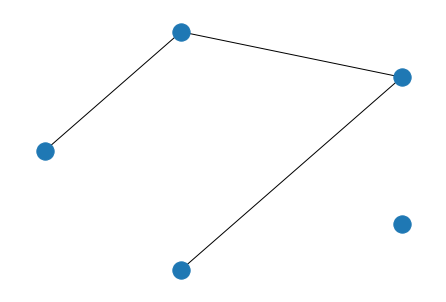

In [9]:
from networkx.generators.random_graphs import erdos_renyi_graph
import networkx as nx
import matplotlib.pyplot as plt

n = 5 # 100K, then 1M, then 10M...
p=0.2
Gs = nx.scale_free_graph(n)
Gr = nx.erdos_renyi_graph(n,p)
#G = nx.complete_graph(4)

#G=nx.barabasi_albert_graph(6,4) 
pr=nx.pagerank(Gr,0.4) 
pr
print(pr)

nx.draw_shell(Gr)
#nx.draw_shell(Gs)
plt.show()

In [19]:
n = 5
p = 0.5
Gr = nx.erdos_renyi_graph(n,p)

In [68]:
methods = [
    'adj',
    'adjacency()',
    'adjlist_inner_dict_factory()',
    'adjlist_outer_dict_factory()',
    'degree()',
    'edge_attr_dict_factory()',
    'edges',
    'graph',
    'graph_attr_dict_factory()',
    'is_directed()',
    'is_multigraph()',
    'name',
    'nbunch_iter()',
    'node_attr_dict_factory()',
    'node_dict_factory()',
    'nodes()',
    'number_of_edges()',
    'number_of_nodes()',
    'order()',
    'size()',
]

In [86]:
def evaluator(graph_varname: str, method_name: str) -> None:
    print(method_name, "\n", 
          eval(f"{graph_varname}.{method_name}"),
          "\n\n")

[evaluator("Gr", method) for method in methods if method[0]!="_"]

adj 
 {0: {1: {}, 2: {}, 3: {}}, 1: {0: {}, 2: {}}, 2: {0: {}, 1: {}, 3: {}, 4: {}}, 3: {0: {}, 2: {}, 4: {}}, 4: {2: {}, 3: {}}} 


adjacency() 


adjlist_inner_dict_factory() 
 {} 


adjlist_outer_dict_factory() 
 {} 


degree() 
 [(0, 3), (1, 2), (2, 4), (3, 3), (4, 2)] 


edge_attr_dict_factory() 
 {} 


edges 
 [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3), (2, 4), (3, 4)] 


graph 
 {} 


graph_attr_dict_factory() 
 {} 


is_directed() 
 False 


is_multigraph() 
 False 


name 
  


nbunch_iter() 


node_attr_dict_factory() 
 {} 


node_dict_factory() 
 {} 


nodes() 
 [0, 1, 2, 3, 4] 


number_of_edges() 
 7 


number_of_nodes() 
 5 


order() 
 5 


size() 
 7 




[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [88]:
dir(Gr)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adj',
 '_node',
 'add_edge',
 'add_edges_from',
 'add_node',
 'add_nodes_from',
 'add_weighted_edges_from',
 'adj',
 'adjacency',
 'adjlist_inner_dict_factory',
 'adjlist_outer_dict_factory',
 'clear',
 'clear_edges',
 'copy',
 'degree',
 'edge_attr_dict_factory',
 'edge_subgraph',
 'edges',
 'get_edge_data',
 'graph',
 'graph_attr_dict_factory',
 'has_edge',
 'has_node',
 'is_directed',
 'is_multigraph',
 'name',
 'nbunch_iter',
 'neighbors',
 'node_attr_dict_factory',
 'node_dict_factory',
 'nodes',
 'number_of_edges',
 'number_of_nodes',
 'order',
 'remove_edg

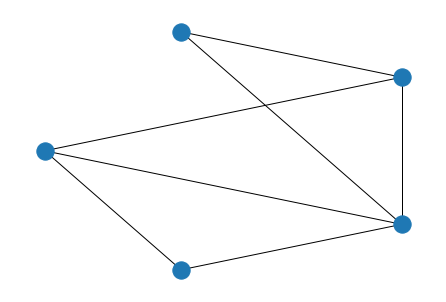

In [25]:
nx.draw_shell(Gr)
#nx.draw_shell(Gs)
plt.show()

In [23]:
pr=nx.pagerank(Gr,0.4) 
pr

{0: 0.20624999999756133,
 1: 0.17187506400121932,
 2: 0.24374987200243864,
 3: 0.20624999999756133,
 4: 0.17187506400121932}

In [27]:
for i in Gr.adjacency():
    print(i)

(0, {1: {}, 2: {}, 3: {}})
(1, {0: {}, 2: {}})
(2, {0: {}, 1: {}, 3: {}, 4: {}})
(3, {0: {}, 2: {}, 4: {}})
(4, {2: {}, 3: {}})


In [24]:
dir(Gr)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adj',
 '_node',
 'add_edge',
 'add_edges_from',
 'add_node',
 'add_nodes_from',
 'add_weighted_edges_from',
 'adj',
 'adjacency',
 'adjlist_inner_dict_factory',
 'adjlist_outer_dict_factory',
 'clear',
 'clear_edges',
 'copy',
 'degree',
 'edge_attr_dict_factory',
 'edge_subgraph',
 'edges',
 'get_edge_data',
 'graph',
 'graph_attr_dict_factory',
 'has_edge',
 'has_node',
 'is_directed',
 'is_multigraph',
 'name',
 'nbunch_iter',
 'neighbors',
 'node_attr_dict_factory',
 'node_dict_factory',
 'nodes',
 'number_of_edges',
 'number_of_nodes',
 'order',
 'remove_edg